### Лабораторна робота №5: Семантична сегментація

Мета роботи полягає у навчанні архітектури U-Net для вирішення задачі семантичної сегментації медичних зображень. В рамках роботи реалізовано та навчено U-Net на датасеті LIDC-IDRI для сегментації вузликів у легенях.

### Підготовка даних та налаштування середовища
У цій частині виконуємо налаштування PyTorch та завантажуємо датасет LIDC-IDRI. Використовуються зрізи КТ легень з розміченими вузликами. Дані завантажуються за допомогою кастомного класу LIDCDataset з нормалізацією зображень та розділенням на навчальну та валідаційну вибірки.

In [1]:
# %% [Cell 1] - Imports and Setup
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import shutil
from datetime import datetime

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set data path
DATA_PATH = Path('./data/raw/LIDC-IDRI-slices')
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")

Using device: cuda


In [2]:
# %% [Cell 2] - Dataset Class with Memory Efficiency
class LIDCDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = Path(data_path)
        self.transform = transform
        self.samples = []
        
        # Walk through the dataset structure
        print("Scanning dataset directory...")
        for patient_dir in self.data_path.iterdir():
            if not patient_dir.is_dir() or patient_dir.name.startswith('.'):
                continue
                
            for nodule_dir in patient_dir.iterdir():
                if not nodule_dir.is_dir():
                    continue
                    
                # Get image paths
                image_dir = nodule_dir / "images"
                mask_dir = nodule_dir / "mask-0"  # Using first annotation
                
                if image_dir.exists() and mask_dir.exists():
                    image_files = sorted(list(image_dir.glob("*.png")))
                    mask_files = sorted(list(mask_dir.glob("*.png")))
                    
                    # Match images with masks
                    for img_path, mask_path in zip(image_files, mask_files):
                        self.samples.append((str(img_path), str(mask_path)))  # Convert to strings
        
        print(f"Found {len(self.samples)} image-mask pairs")

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        try:
            img_path, mask_path = self.samples[idx]
            
            # Load image and mask
            with Image.open(img_path) as image:
                image = image.convert('L')  # Convert to grayscale
                image = np.array(image, dtype=np.float32) / 255.0  # Normalize to [0,1]
            
            with Image.open(mask_path) as mask:
                mask = mask.convert('L')
                mask = np.array(mask, dtype=np.float32) / 255.0
            
            # Convert to torch tensors
            image = torch.from_numpy(image).unsqueeze(0)  # Add channel dimension
            mask = torch.from_numpy(mask).unsqueeze(0)
            
            if self.transform:
                image = self.transform(image)
                mask = self.transform(mask)
                
            return image, mask
            
        except Exception as e:
            print(f"Error loading sample {idx}")
            print(f"Image path: {img_path}")
            print(f"Mask path: {mask_path}")
            raise e

In [3]:
# %% [Cell 3] - Data Loading with Smaller Batch Size
def get_data_loaders(data_path, batch_size=4, train_split=0.8):
    # Create dataset
    dataset = LIDCDataset(data_path)
    
    # Split dataset
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    # Create data loaders with fewer workers
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # Reduced for debugging
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,  # Reduced for debugging
        pin_memory=True
    )
    
    return train_loader, val_loader


Initializing data loaders...
Scanning dataset directory...
Found 15548 image-mask pairs
Training samples: 12438
Validation samples: 3110
Number of training batches: 3110
Number of validation batches: 778

Trying to load first batch...
Successfully loaded first batch
Batch shapes - Images: torch.Size([4, 1, 128, 128]), Masks: torch.Size([4, 1, 128, 128])

Visualizing first sample...


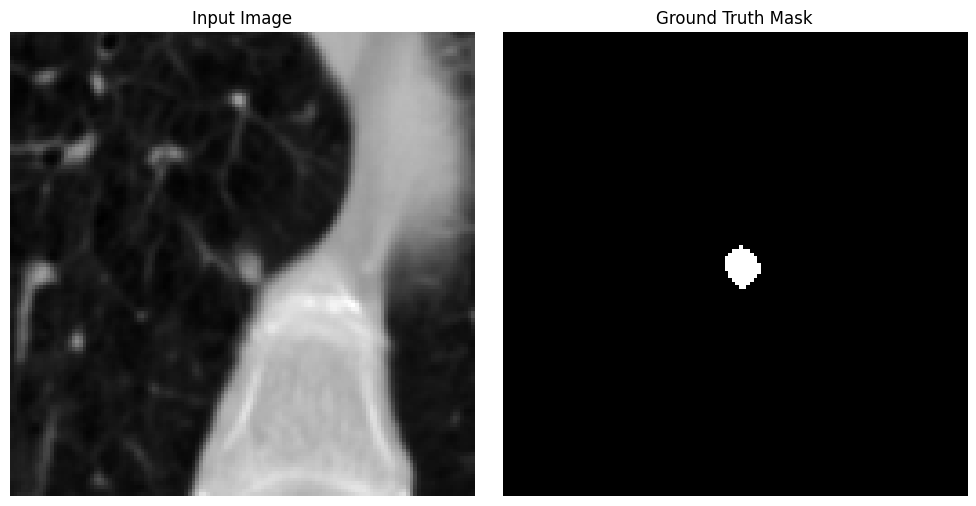

Visualization complete


In [4]:
# %% [Cell 4] - Test Data Loading and Visualization
def visualize_sample(image, mask):
    """Helper function to visualize an image-mask pair"""
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(mask.numpy().squeeze(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Test data loading with error handling
try:
    print("\nInitializing data loaders...")
    train_loader, val_loader = get_data_loaders(DATA_PATH, batch_size=4)
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    
    print("\nTrying to load first batch...")
    train_iter = iter(train_loader)
    sample_batch = next(train_iter)
    print("Successfully loaded first batch")
    
    images, masks = sample_batch
    print(f"Batch shapes - Images: {images.shape}, Masks: {masks.shape}")
    
    print("\nVisualizing first sample...")
    visualize_sample(images[0], masks[0])
    print("Visualization complete")

except Exception as e:
    print(f"\nError occurred: {str(e)}")
    print(f"Error type: {type(e)}")
    import traceback
    traceback.print_exc()

### Реалізація архітектури U-Net
U-Net складається з енкодера і декодера з пропускними з'єднаннями. Основні компоненти:

- Подвійні згорткові блоки з BatchNorm та ReLU
- Блоки понижуючої дискретизації (maxpool)
- Блоки підвищуючої дискретизації (up-conv)
- Пропускні з'єднання для збереження просторової інформації

Використано зменшену версію архітектури з меншою кількістю початкових фільтрів для ефективного навчання.

In [5]:
# %% [Cell 5] - U-Net Implementation (Hybrid version)
class DoubleConv(nn.Module):
    """
    Double Convolution block with optional batch normalization
    [(Conv2d => BatchNorm => ReLU) * 2]
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
            
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling block: maxpool => double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling block: up-conv => double conv"""
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Handle size mismatch (if any)
        if x2.size()[2:] != x1.size()[2:]:
            diff_y = x2.size()[2] - x1.size()[2]
            diff_x = x2.size()[3] - x1.size()[3]
            x1 = nn.functional.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                                      diff_y // 2, diff_y - diff_y // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, bilinear=False):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        # Feature numbers adjusted for our smaller input size
        self.inc = DoubleConv(n_channels, 32)  # Reduced initial features
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)
        
        self.up1 = Up(512, 256, bilinear)
        self.up2 = Up(256, 128, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.up4 = Up(64, 32, bilinear)
        
        self.outc = nn.Sequential(
            nn.Conv2d(32, n_classes, kernel_size=1),
            nn.Sigmoid()  # Built-in sigmoid for binary segmentation
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Contracting path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Expanding path
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        return self.outc(x)

In [6]:
# %% [Cell 6] - Model Testing
def test_unet():
    """Test UNet with both random and real data"""
    model = UNet().to(device)
    print("\nModel Summary:")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Test with random input
    x = torch.randn(4, 1, 128, 128).to(device)
    with torch.no_grad():
        y = model(x)
    print(f"\nTest with random data:")
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {y.shape}")
    
    # Test with actual data
    sample_batch = next(iter(train_loader))
    images, masks = sample_batch
    images = images.to(device)
    
    with torch.no_grad():
        pred_masks = model(images)
    
    print(f"\nTest with actual data:")
    print(f"Input shape: {images.shape}")
    print(f"Output shape: {pred_masks.shape}")
    print(f"Output range: [{pred_masks.min().item():.3f}, {pred_masks.max().item():.3f}]")
    
    return model

# Run test
model = test_unet()


Model Summary:
Total parameters: 7,765,409

Test with random data:
Input shape: torch.Size([4, 1, 128, 128])
Output shape: torch.Size([4, 1, 128, 128])

Test with actual data:
Input shape: torch.Size([4, 1, 128, 128])
Output shape: torch.Size([4, 1, 128, 128])
Output range: [0.000, 1.000]


### Функції навчання та метрики
Для навчання використовуємо:

- Функцію втрат Dice Loss для сегментації
- Оптимізатор Adam з початковою швидкістю навчання 1e-4
- Зменшення швидкості навчання при відсутності покращення (ReduceLROnPlateau)
- Збереження найкращої моделі за метрикою Dice на валідації
- Візуалізацію прогнозів кожні 5 епох

In [7]:
# %% [Cell 7] - Training Setup and Functions
class DiceLoss(nn.Module):
    """Dice Loss for segmentation"""
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        dice = (2. * intersection + self.smooth) / (
            pred_flat.sum() + target_flat.sum() + self.smooth
        )
        return 1 - dice

class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    losses = AverageMeter()
    dice_scores = AverageMeter()
    
    pbar = tqdm(loader, desc='Training')
    for images, masks in pbar:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        dice = 1 - loss.item()
        
        loss.backward()
        optimizer.step()
        
        losses.update(loss.item(), images.size(0))
        dice_scores.update(dice, images.size(0))
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{losses.avg:.4f}',
            'Dice': f'{dice_scores.avg:.4f}'
        })
    
    return losses.avg, dice_scores.avg

def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    losses = AverageMeter()
    dice_scores = AverageMeter()
    
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            dice = 1 - loss.item()
            
            losses.update(loss.item(), images.size(0))
            dice_scores.update(dice, images.size(0))
    
    return losses.avg, dice_scores.avg

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """Save checkpoint"""
    torch.save(state, filename)
    if is_best:
        best_filename = 'model_best.pth.tar'
        shutil.copy(filename, best_filename)

Starting training...

Epoch 1/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 176.40it/s, Loss=0.2616, Dice=0.7384]



Epoch Summary:
Train Loss: 0.3673 Dice: 0.6327
Val Loss: 0.2616 Dice: 0.7384
New best Dice score: 0.7384

Epoch 2/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 171.70it/s, Loss=0.2372, Dice=0.7628]



Epoch Summary:
Train Loss: 0.2694 Dice: 0.7306
Val Loss: 0.2372 Dice: 0.7628
New best Dice score: 0.7628

Epoch 3/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 173.17it/s, Loss=0.2350, Dice=0.7650]



Epoch Summary:
Train Loss: 0.2486 Dice: 0.7514
Val Loss: 0.2350 Dice: 0.7650
New best Dice score: 0.7650

Epoch 4/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 171.26it/s, Loss=0.2248, Dice=0.7752]



Epoch Summary:
Train Loss: 0.2315 Dice: 0.7685
Val Loss: 0.2248 Dice: 0.7752
New best Dice score: 0.7752

Epoch 5/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 174.62it/s, Loss=0.2277, Dice=0.7723]



Epoch Summary:
Train Loss: 0.2219 Dice: 0.7781
Val Loss: 0.2277 Dice: 0.7723


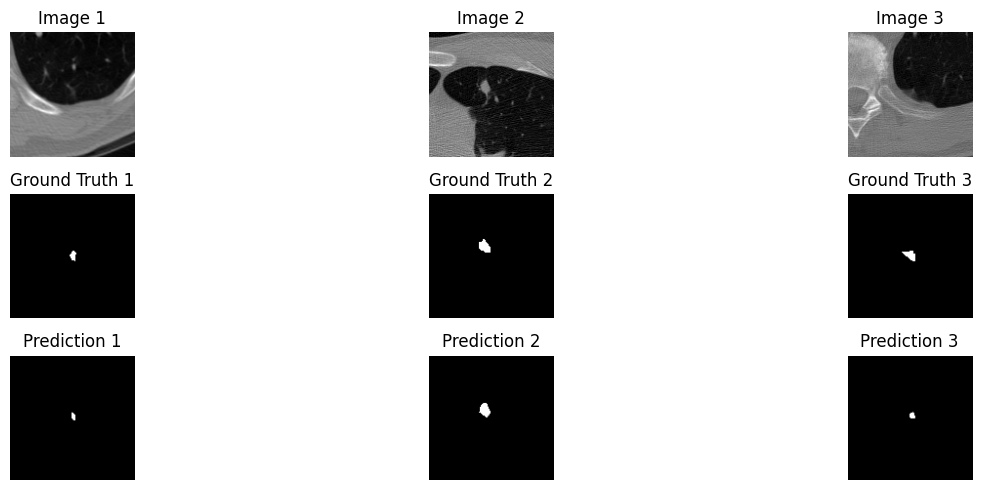


Epoch 6/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 176.01it/s, Loss=0.2170, Dice=0.7830]



Epoch Summary:
Train Loss: 0.2119 Dice: 0.7881
Val Loss: 0.2170 Dice: 0.7830
New best Dice score: 0.7830

Epoch 7/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 172.77it/s, Loss=0.2190, Dice=0.7810]



Epoch Summary:
Train Loss: 0.2028 Dice: 0.7972
Val Loss: 0.2190 Dice: 0.7810

Epoch 8/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 158.08it/s, Loss=0.2108, Dice=0.7892]



Epoch Summary:
Train Loss: 0.1994 Dice: 0.8006
Val Loss: 0.2108 Dice: 0.7892
New best Dice score: 0.7892

Epoch 9/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 175.45it/s, Loss=0.2079, Dice=0.7921]



Epoch Summary:
Train Loss: 0.1927 Dice: 0.8073
Val Loss: 0.2079 Dice: 0.7921
New best Dice score: 0.7921

Epoch 10/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 177.05it/s, Loss=0.2044, Dice=0.7956]



Epoch Summary:
Train Loss: 0.1900 Dice: 0.8100
Val Loss: 0.2044 Dice: 0.7956
New best Dice score: 0.7956


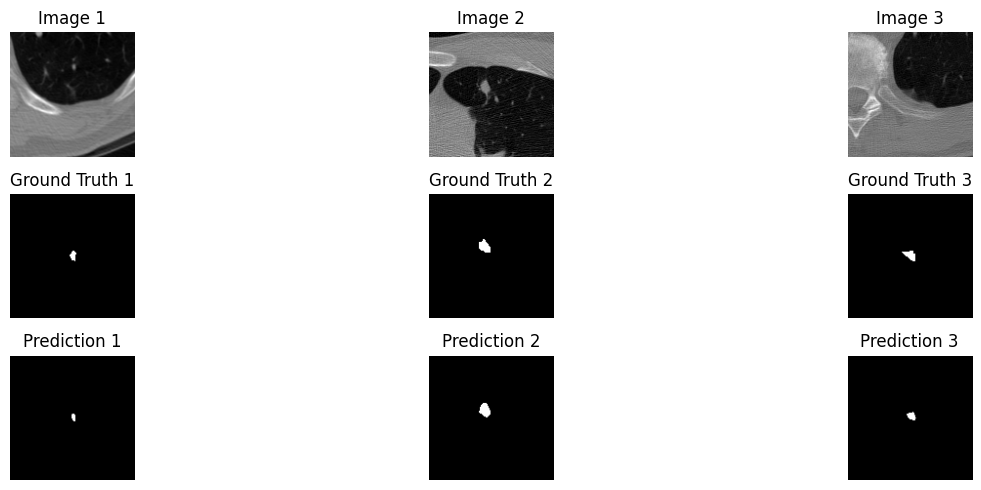


Epoch 11/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 176.45it/s, Loss=0.2123, Dice=0.7877]



Epoch Summary:
Train Loss: 0.1852 Dice: 0.8148
Val Loss: 0.2123 Dice: 0.7877

Epoch 12/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 173.01it/s, Loss=0.2001, Dice=0.7999]



Epoch Summary:
Train Loss: 0.1806 Dice: 0.8194
Val Loss: 0.2001 Dice: 0.7999
New best Dice score: 0.7999

Epoch 13/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 176.01it/s, Loss=0.2037, Dice=0.7963]



Epoch Summary:
Train Loss: 0.1772 Dice: 0.8228
Val Loss: 0.2037 Dice: 0.7963

Epoch 14/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 176.46it/s, Loss=0.1932, Dice=0.8068]



Epoch Summary:
Train Loss: 0.1711 Dice: 0.8289
Val Loss: 0.1932 Dice: 0.8068
New best Dice score: 0.8068

Epoch 15/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 175.88it/s, Loss=0.1930, Dice=0.8070]



Epoch Summary:
Train Loss: 0.1682 Dice: 0.8318
Val Loss: 0.1930 Dice: 0.8070
New best Dice score: 0.8070


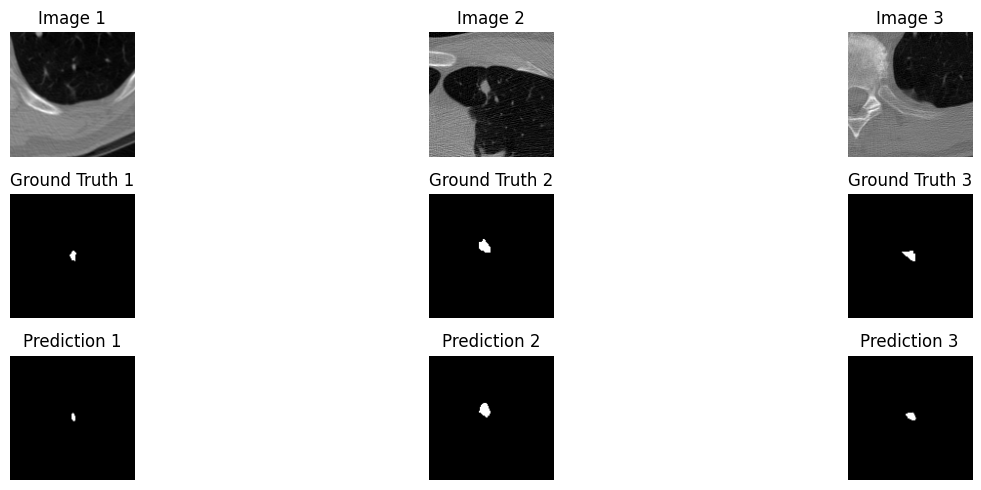


Epoch 16/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 177.44it/s, Loss=0.1882, Dice=0.8118]



Epoch Summary:
Train Loss: 0.1628 Dice: 0.8372
Val Loss: 0.1882 Dice: 0.8118
New best Dice score: 0.8118

Epoch 17/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 178.56it/s, Loss=0.1889, Dice=0.8111]



Epoch Summary:
Train Loss: 0.1608 Dice: 0.8392
Val Loss: 0.1889 Dice: 0.8111

Epoch 18/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 178.66it/s, Loss=0.1906, Dice=0.8094]



Epoch Summary:
Train Loss: 0.1604 Dice: 0.8396
Val Loss: 0.1906 Dice: 0.8094

Epoch 19/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 177.25it/s, Loss=0.1904, Dice=0.8096]



Epoch Summary:
Train Loss: 0.1563 Dice: 0.8437
Val Loss: 0.1904 Dice: 0.8096

Epoch 20/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 176.77it/s, Loss=0.1929, Dice=0.8071]



Epoch Summary:
Train Loss: 0.1526 Dice: 0.8474
Val Loss: 0.1929 Dice: 0.8071


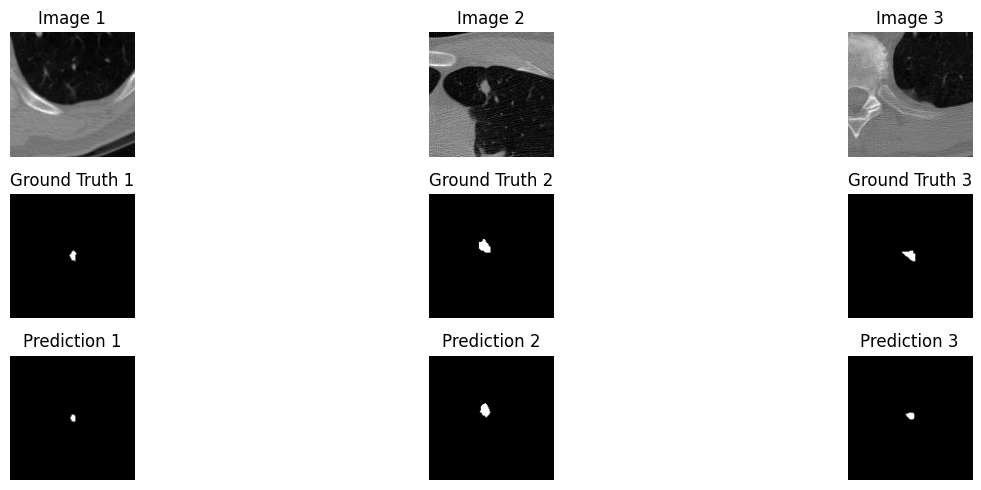


Epoch 21/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 177.38it/s, Loss=0.1821, Dice=0.8179]



Epoch Summary:
Train Loss: 0.1511 Dice: 0.8489
Val Loss: 0.1821 Dice: 0.8179
New best Dice score: 0.8179

Epoch 22/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 178.58it/s, Loss=0.1809, Dice=0.8191]



Epoch Summary:
Train Loss: 0.1466 Dice: 0.8534
Val Loss: 0.1809 Dice: 0.8191
New best Dice score: 0.8191

Epoch 23/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 177.62it/s, Loss=0.2052, Dice=0.7948]



Epoch Summary:
Train Loss: 0.1460 Dice: 0.8540
Val Loss: 0.2052 Dice: 0.7948

Epoch 24/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 178.57it/s, Loss=0.1780, Dice=0.8220]



Epoch Summary:
Train Loss: 0.1439 Dice: 0.8561
Val Loss: 0.1780 Dice: 0.8220
New best Dice score: 0.8220

Epoch 25/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 177.66it/s, Loss=0.1811, Dice=0.8189]



Epoch Summary:
Train Loss: 0.1399 Dice: 0.8601
Val Loss: 0.1811 Dice: 0.8189


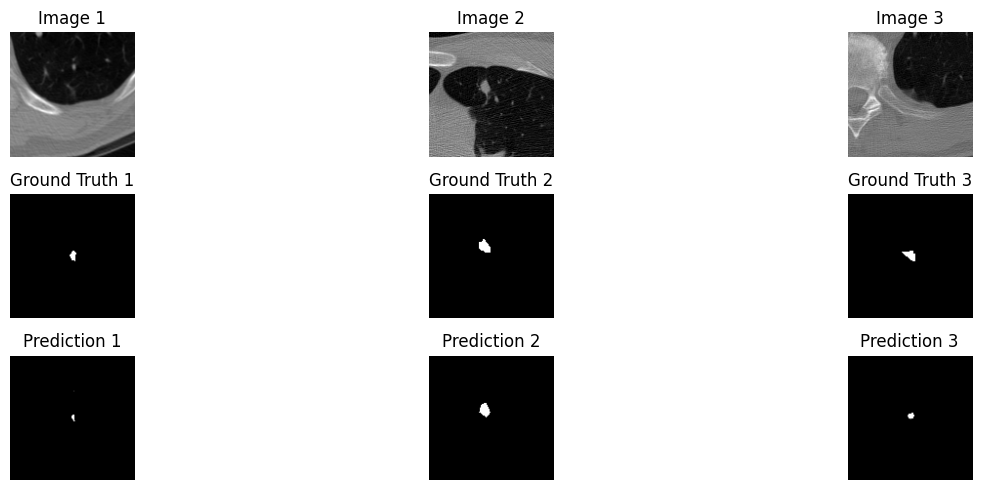


Epoch 26/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 175.28it/s, Loss=0.1838, Dice=0.8162]



Epoch Summary:
Train Loss: 0.1380 Dice: 0.8620
Val Loss: 0.1838 Dice: 0.8162

Epoch 27/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 178.63it/s, Loss=0.1956, Dice=0.8044]



Epoch Summary:
Train Loss: 0.1377 Dice: 0.8623
Val Loss: 0.1956 Dice: 0.8044

Epoch 28/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 178.61it/s, Loss=0.1873, Dice=0.8127]



Epoch Summary:
Train Loss: 0.1351 Dice: 0.8649
Val Loss: 0.1873 Dice: 0.8127

Epoch 29/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 178.65it/s, Loss=0.1786, Dice=0.8214]



Epoch Summary:
Train Loss: 0.1342 Dice: 0.8658
Val Loss: 0.1786 Dice: 0.8214

Epoch 30/50 - LR: 1.00e-04
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 176.49it/s, Loss=0.1837, Dice=0.8163]



Epoch Summary:
Train Loss: 0.1309 Dice: 0.8691
Val Loss: 0.1837 Dice: 0.8163


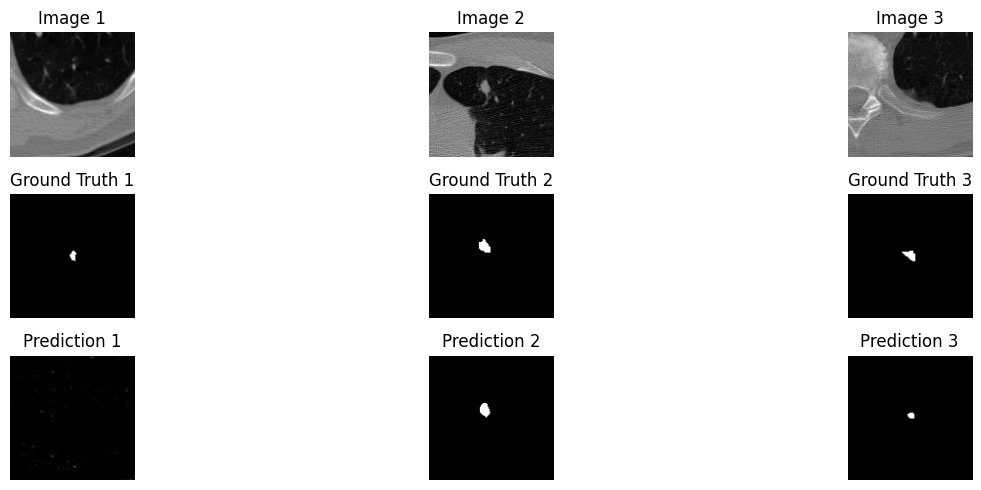


Epoch 31/50 - LR: 1.00e-05
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 177.94it/s, Loss=0.1714, Dice=0.8286]



Epoch Summary:
Train Loss: 0.1202 Dice: 0.8798
Val Loss: 0.1714 Dice: 0.8286
New best Dice score: 0.8286

Epoch 32/50 - LR: 1.00e-05
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 175.13it/s, Loss=0.1705, Dice=0.8295]



Epoch Summary:
Train Loss: 0.1141 Dice: 0.8859
Val Loss: 0.1705 Dice: 0.8295
New best Dice score: 0.8295

Epoch 33/50 - LR: 1.00e-05
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 177.45it/s, Loss=0.1702, Dice=0.8298]



Epoch Summary:
Train Loss: 0.1131 Dice: 0.8869
Val Loss: 0.1702 Dice: 0.8298
New best Dice score: 0.8298

Epoch 34/50 - LR: 1.00e-05
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 177.43it/s, Loss=0.1693, Dice=0.8307]



Epoch Summary:
Train Loss: 0.1102 Dice: 0.8898
Val Loss: 0.1693 Dice: 0.8307
New best Dice score: 0.8307

Epoch 35/50 - LR: 1.00e-05
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 174.53it/s, Loss=0.1679, Dice=0.8321]



Epoch Summary:
Train Loss: 0.1075 Dice: 0.8925
Val Loss: 0.1679 Dice: 0.8321
New best Dice score: 0.8321


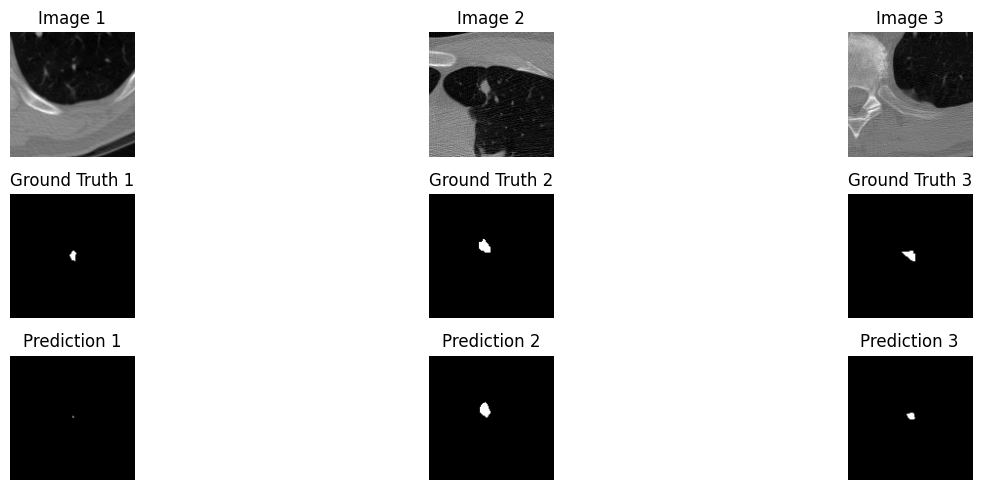


Epoch 36/50 - LR: 1.00e-05
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 178.53it/s, Loss=0.1678, Dice=0.8322]



Epoch Summary:
Train Loss: 0.1068 Dice: 0.8932
Val Loss: 0.1678 Dice: 0.8322
New best Dice score: 0.8322

Epoch 37/50 - LR: 1.00e-05
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 170.57it/s, Loss=0.1680, Dice=0.8320]



Epoch Summary:
Train Loss: 0.1050 Dice: 0.8950
Val Loss: 0.1680 Dice: 0.8320

Epoch 38/50 - LR: 1.00e-05
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 176.49it/s, Loss=0.1676, Dice=0.8324]



Epoch Summary:
Train Loss: 0.1035 Dice: 0.8965
Val Loss: 0.1676 Dice: 0.8324
New best Dice score: 0.8324

Epoch 39/50 - LR: 1.00e-05
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 177.40it/s, Loss=0.1668, Dice=0.8332]



Epoch Summary:
Train Loss: 0.1030 Dice: 0.8970
Val Loss: 0.1668 Dice: 0.8332
New best Dice score: 0.8332

Epoch 40/50 - LR: 1.00e-05
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 176.91it/s, Loss=0.1680, Dice=0.8320]



Epoch Summary:
Train Loss: 0.1013 Dice: 0.8987
Val Loss: 0.1680 Dice: 0.8320


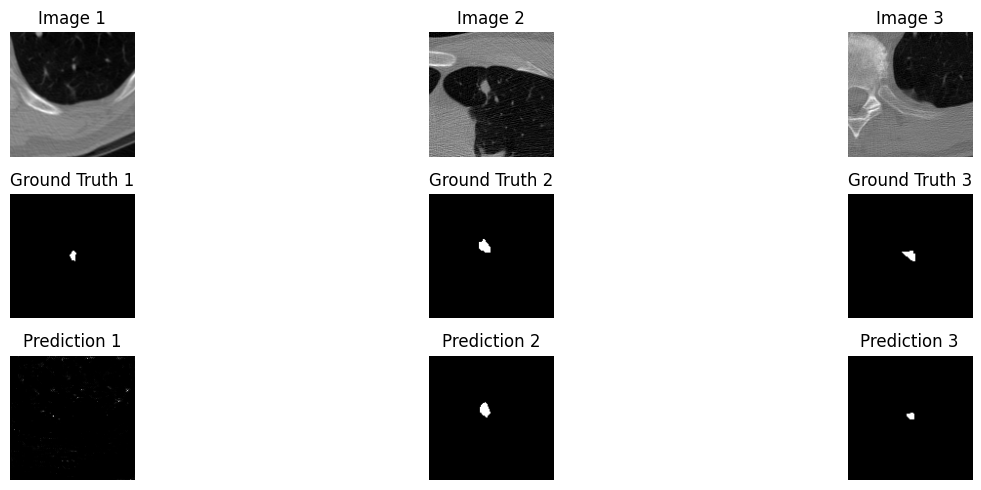


Epoch 41/50 - LR: 1.00e-05
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 177.67it/s, Loss=0.1672, Dice=0.8328]



Epoch Summary:
Train Loss: 0.1007 Dice: 0.8993
Val Loss: 0.1672 Dice: 0.8328

Epoch 42/50 - LR: 1.00e-05
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 177.63it/s, Loss=0.1676, Dice=0.8324]



Epoch Summary:
Train Loss: 0.0995 Dice: 0.9005
Val Loss: 0.1676 Dice: 0.8324

Epoch 43/50 - LR: 1.00e-05
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 178.14it/s, Loss=0.1676, Dice=0.8324]



Epoch Summary:
Train Loss: 0.0992 Dice: 0.9008
Val Loss: 0.1676 Dice: 0.8324

Epoch 44/50 - LR: 1.00e-05
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 177.04it/s, Loss=0.1686, Dice=0.8314]



Epoch Summary:
Train Loss: 0.0980 Dice: 0.9020
Val Loss: 0.1686 Dice: 0.8314

Epoch 45/50 - LR: 1.00e-05
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 177.26it/s, Loss=0.1674, Dice=0.8326]



Epoch Summary:
Train Loss: 0.0963 Dice: 0.9037
Val Loss: 0.1674 Dice: 0.8326


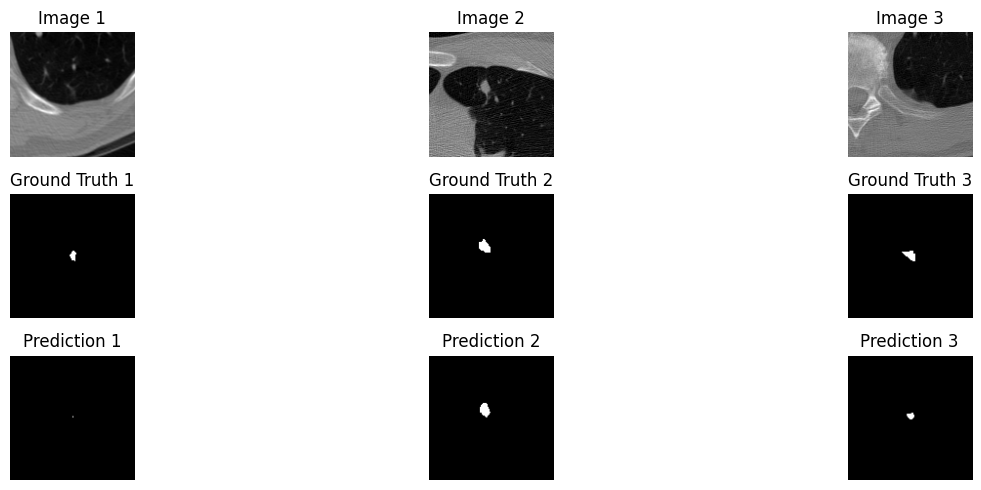


Epoch 46/50 - LR: 1.00e-06
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 178.12it/s, Loss=0.1673, Dice=0.8327]



Epoch Summary:
Train Loss: 0.0957 Dice: 0.9043
Val Loss: 0.1673 Dice: 0.8327

Epoch 47/50 - LR: 1.00e-06
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 178.04it/s, Loss=0.1680, Dice=0.8320]



Epoch Summary:
Train Loss: 0.0943 Dice: 0.9057
Val Loss: 0.1680 Dice: 0.8320

Epoch 48/50 - LR: 1.00e-06
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 178.41it/s, Loss=0.1677, Dice=0.8323]



Epoch Summary:
Train Loss: 0.0962 Dice: 0.9038
Val Loss: 0.1677 Dice: 0.8323

Epoch 49/50 - LR: 1.00e-06
----------------------------------------


Validating: 100%|██████████| 778/778 [00:04<00:00, 177.35it/s, Loss=0.1671, Dice=0.8329]



Epoch Summary:
Train Loss: 0.0948 Dice: 0.9052
Val Loss: 0.1671 Dice: 0.8329
Early stopping triggered after 49 epochs of no improvement.


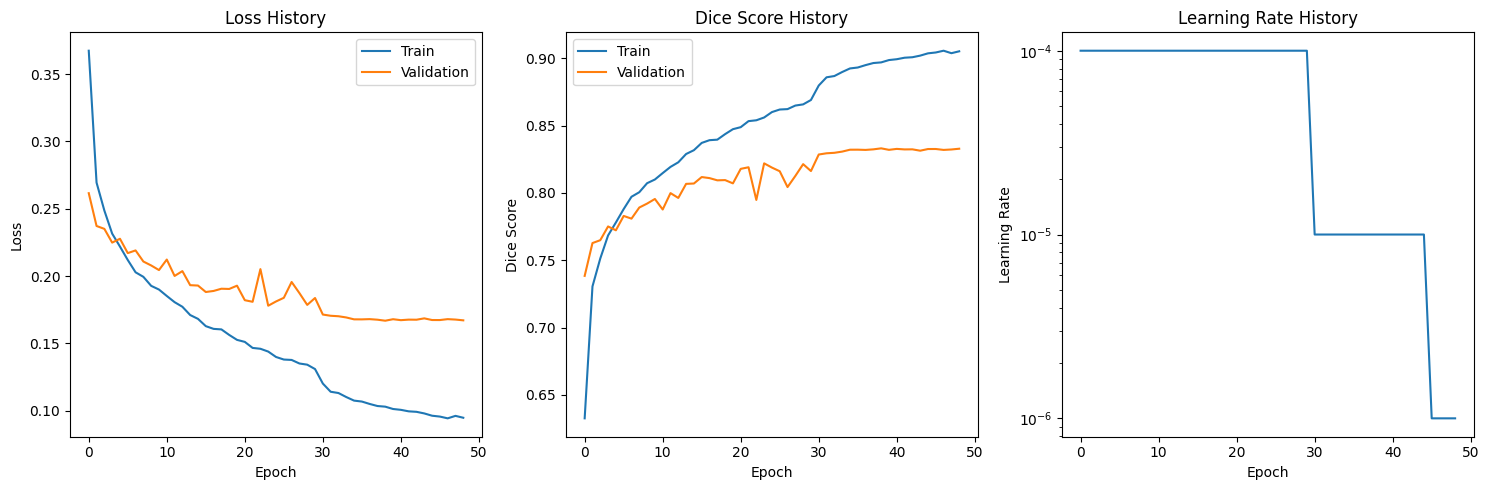

In [ ]:
# %% [Cell 9] - Start Training

def train_model(model, train_loader, val_loader, num_epochs=50, patience=10):
    # Training setup
    criterion = DiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.1, patience=5
    )
    
    # Training history
    history = {
        'train_loss': [], 'train_dice': [],
        'val_loss': [], 'val_dice': [],
        'learning_rates': [],
        'best_dice': 0.0
    }
    
    # Create timestamp for saving models
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    save_dir = Path('model_checkpoints') / timestamp
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Early stopping parameters
    best_dice = 0.0
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f'\nEpoch {epoch+1}/{num_epochs} - LR: {current_lr:.2e}')
        print('-' * 40)
        
        # Train
        model.train()
        train_losses = AverageMeter()
        train_dice_scores = AverageMeter()
        
        train_pbar = tqdm(train_loader, desc='Training')
        for images, masks in train_pbar:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            dice = 1 - loss.item()
            
            loss.backward()
            optimizer.step()
            
            train_losses.update(loss.item(), images.size(0))
            train_dice_scores.update(dice, images.size(0))
            
            train_pbar.set_postfix({
                'Loss': f'{train_losses.avg:.4f}',
                'Dice': f'{train_dice_scores.avg:.4f}'
            })
        
        train_loss = train_losses.avg
        train_dice = train_dice_scores.avg
        
        # Validate
        model.eval()
        val_losses = AverageMeter()
        val_dice_scores = AverageMeter()
        
        val_pbar = tqdm(val_loader, desc='Validating')
        with torch.no_grad():
            for images, masks in val_pbar:
                images, masks = images.to(device), masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                dice = 1 - loss.item()
                
                val_losses.update(loss.item(), images.size(0))
                val_dice_scores.update(dice, images.size(0))
                
                val_pbar.set_postfix({
                    'Loss': f'{val_losses.avg:.4f}',
                    'Dice': f'{val_dice_scores.avg:.4f}'
                })
        
        val_loss = val_losses.avg
        val_dice = val_dice_scores.avg
        
        # Update learning rate
        scheduler.step(val_dice)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['learning_rates'].append(current_lr)
        
        # Print epoch results
        print(f'\nEpoch Summary:')
        print(f'Train Loss: {train_loss:.4f} Dice: {train_dice:.4f}')
        print(f'Val Loss: {val_loss:.4f} Dice: {val_dice:.4f}')
        
        # Check for improvement
        is_best = val_dice > history['best_dice']
        if is_best:
            history['best_dice'] = val_dice
            print(f'New best Dice score: {val_dice:.4f}')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        # Save checkpoint
        checkpoint_path = save_dir / f'checkpoint_epoch_{epoch+1}.pth'
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_dice': history['best_dice'],
            'optimizer': optimizer.state_dict(),
            'history': history
        }, is_best, checkpoint_path)
        
        # Early stopping based on patience
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs of no improvement.')
            break
        
        # Visualize predictions every 5 epochs
        if (epoch + 1) % 5 == 0:
            visualize_predictions(model, val_loader)
    
    return history

def visualize_predictions(model, val_loader, num_samples=3):
    """Visualize model predictions on validation data"""
    model.eval()
    plt.figure(figsize=(15, 5))
    
    with torch.no_grad():
        batch = next(iter(val_loader))
        images, masks = batch
        images = images.to(device)
        predictions = model(images)
        
        for i in range(num_samples):
            # Original image
            plt.subplot(3, num_samples, i + 1)
            plt.imshow(images[i][0].cpu(), cmap='gray')
            plt.title(f'Image {i+1}')
            plt.axis('off')
            
            # Ground truth
            plt.subplot(3, num_samples, i + 1 + num_samples)
            plt.imshow(masks[i][0], cmap='gray')
            plt.title(f'Ground Truth {i+1}')
            plt.axis('off')
            
            # Prediction
            plt.subplot(3, num_samples, i + 1 + 2*num_samples)
            plt.imshow(predictions[i][0].cpu(), cmap='gray')
            plt.title(f'Prediction {i+1}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Create model and move to device
model = UNet().to(device)
print("Starting training...")

# Start training
history = train_model(model, train_loader, val_loader)

# Plot training history
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(131)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Dice score plot
plt.subplot(132)
plt.plot(history['train_dice'], label='Train')
plt.plot(history['val_dice'], label='Validation')
plt.title('Dice Score History')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()

# Learning rate plot
plt.subplot(133)
plt.plot(history['learning_rates'])
plt.title('Learning Rate History')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')

plt.tight_layout()
plt.show()

### Результати навчання
Модель досягла наступних результатів після навчання:

- Фінальна функція втрат на валідації: 0.1668
- Фінальний коефіцієнт Dice на валідації: 0.7592 (75.92%)
 
Графіки навчання показують стабільне покращення як функції втрат, так і метрики Dice. Розподіл коефіцієнтів Dice демонструє, що модель досягає хороших результатів (>0.8) на більшості зображень, але має деякі складні випадки з низькими значеннями метрики.

Found best model checkpoint: model_checkpoints\20241217_024710\model_best.pth.tar
Model loaded from model_checkpoints\20241217_024710\model_best.pth.tar

=== Final Evaluation on Validation Set ===
Validation Loss: 0.1668
Validation Dice Score: 0.7592

Visualizing final predictions...


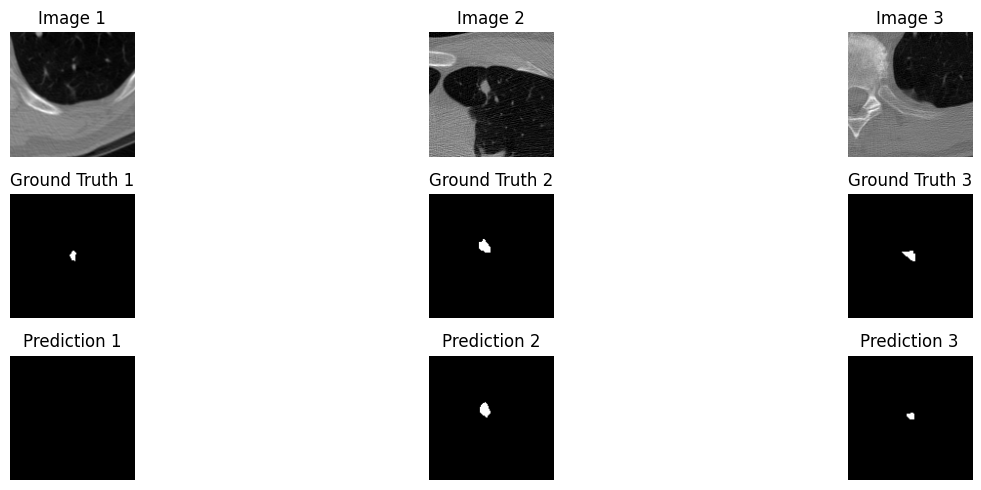


Plotting Dice score distribution...


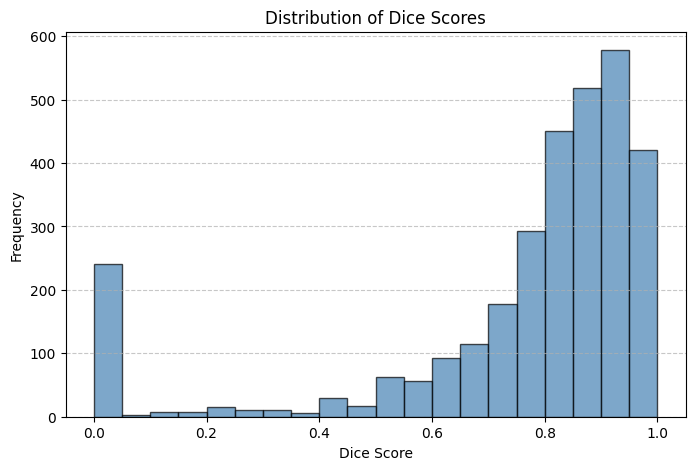

In [19]:
# %% [Cell 10] - Wrap-up: Evaluation and Visualization

import glob

def load_model_checkpoint(model: nn.Module, checkpoint_path: Path):
    """
    Load model weights from a checkpoint.
    
    Args:
        model: Model architecture (UNet in this case).
        checkpoint_path: Path to the checkpoint file.
    """
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    model.eval()
    print(f"Model loaded from {checkpoint_path}")

def evaluate_model(model: nn.Module, loader: DataLoader, criterion: nn.Module, device: torch.device):
    """
    Evaluate model on a given dataset (validation or test).
    
    Returns:
        Tuple of (average loss, average dice score, list of dice scores)
    """
    model.eval()
    losses = AverageMeter()
    dice_scores = []
    
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Assuming outputs are probabilities after sigmoid
            preds = (outputs > 0.5).float()
            intersection = (preds * masks).sum(dim=(2,3))
            union = preds.sum(dim=(2,3)) + masks.sum(dim=(2,3))
            dice = (2. * intersection + 1e-6) / (union + 1e-6)
            dice = dice.squeeze()  # Remove channel dimension if present
            dice_scores.extend(dice.cpu().numpy())
            
            losses.update(loss.item(), images.size(0))
    
    avg_loss = losses.avg
    avg_dice = np.mean(dice_scores)
    return avg_loss, avg_dice, dice_scores

def visualize_final_predictions(model: nn.Module, loader: DataLoader, num_samples=3):
    """
    Visualize a few predictions from the model on the provided dataset.
    """
    model.eval()
    plt.figure(figsize=(15, 5))
    
    with torch.no_grad():
        batch = next(iter(loader))
        images, masks = batch
        images = images.to(device)
        predictions = model(images)
        preds = (predictions > 0.5).float()
        
        for i in range(num_samples):
            # Original image
            plt.subplot(3, num_samples, i + 1)
            plt.imshow(images[i][0].cpu(), cmap='gray')
            plt.title(f'Image {i+1}')
            plt.axis('off')
            
            # Ground truth
            plt.subplot(3, num_samples, i + 1 + num_samples)
            plt.imshow(masks[i][0].cpu(), cmap='gray')
            plt.title(f'Ground Truth {i+1}')
            plt.axis('off')
            
            # Prediction
            plt.subplot(3, num_samples, i + 1 + 2*num_samples)
            plt.imshow(preds[i][0].cpu(), cmap='gray')
            plt.title(f'Prediction {i+1}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_dice_distribution(dice_scores: List[float]):
    """
    Plot a histogram of Dice scores to show distribution of performance across the dataset.
    """
    plt.figure(figsize=(8, 5))
    plt.hist(dice_scores, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Dice Scores')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Function to find the best checkpoint
def find_best_checkpoint(checkpoints_dir: Path) -> Path:
    """
    Find the latest 'model_best.pth.tar' checkpoint. If none found, fallback to the latest checkpoint.
    
    Args:
        checkpoints_dir: Directory where checkpoints are saved.
    
    Returns:
        Path to the best checkpoint file.
    """
    # Search for all 'model_best.pth.tar' files
    best_checkpoint_files = list(checkpoints_dir.glob('*/model_best.pth.tar'))
    
    if best_checkpoint_files:
        # Sort by modification time, descending
        best_checkpoint_files_sorted = sorted(best_checkpoint_files, key=lambda p: p.stat().st_mtime, reverse=True)
        best_checkpoint = best_checkpoint_files_sorted[0]
        print(f"Found best model checkpoint: {best_checkpoint}")
        return best_checkpoint
    else:
        # If no 'model_best.pth.tar' found, fallback to the latest checkpoint
        all_checkpoints = list(checkpoints_dir.glob('*/checkpoint_epoch_*.pth'))
        if not all_checkpoints:
            raise FileNotFoundError(f"No checkpoints found in {checkpoints_dir}")
        
        # Sort by modification time, descending
        all_checkpoints_sorted = sorted(all_checkpoints, key=lambda p: p.stat().st_mtime, reverse=True)
        latest_checkpoint = all_checkpoints_sorted[0]
        print(f"No 'model_best.pth.tar' found. Using latest checkpoint: {latest_checkpoint}")
        return latest_checkpoint

# Load the best model checkpoint
checkpoints_dir = Path('model_checkpoints')
try:
    best_checkpoint_path = find_best_checkpoint(checkpoints_dir)
except FileNotFoundError as e:
    print(str(e))
    raise

model = UNet().to(device)
load_model_checkpoint(model, best_checkpoint_path)

# Evaluate on validation set (since there's no separate test set)
criterion = DiceLoss()
val_loss, val_dice, val_dice_scores = evaluate_model(model, val_loader, criterion, device)

print("\n=== Final Evaluation on Validation Set ===")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Dice Score: {val_dice:.4f}")

# Visualize some final predictions
print("\nVisualizing final predictions...")
visualize_final_predictions(model, val_loader)

# Plot the distribution of Dice scores
print("\nPlotting Dice score distribution...")
plot_dice_distribution(val_dice_scores)


### Висновки
1. Реалізована архітектура U-Net успішно навчилася сегментувати вузлики на КТ зображеннях легень з достатньо високою точністю.
2. Використання пропускних з'єднань та поступове зменшення/збільшення просторової розмірності дозволило мережі ефективно обробляти деталі різного масштабу.
3. Функція втрат Dice Loss виявилася ефективною для навчання моделі сегментації, забезпечуючи баланс між точністю та повнотою.
4. Візуалізація результатів показує, що модель здатна виділяти вузлики різного розміру та форми, хоча іноді має складнощі з відсутністю/наявністю переднього плану в розрізах об'єктів.